In [1]:
import pandas as pd
import json
import plotly.express as px
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

# Original model

In [2]:
f = open('original_classes/VG-SGG-dicts-vgoi6-clipped.json')
 
original_classes = json.load(f)
print("original number of categories: ",len(original_classes["label_to_idx"]))

original number of categories:  1594


In [3]:
df_original_classes = pd.DataFrame({"class": original_classes["object_count"].keys(), "count": original_classes["object_count"].values()})
df_original_classes.head()

class  count
0  window  53848
1    tree  50339
2     man  47202
3  person  43031
4   shirt  38238

In [4]:
df_original_classes[df_original_classes["count"]<200]

class  count
922               pie    199
923             flame    198
924           coaster    197
925           manhole    197
926          radiator    195
...               ...    ...
1589            kitty     27
1590  cooking utensil     26
1591     serving tray     25
1592    swimming pool     22
1593      mixing bowl     16

[672 rows x 2 columns]

In [5]:
df = df_original_classes[0:20]
fig = px.histogram(df, 
                   x=df["class"], 
                   y=df["count"], 
                   title="The 20 most frequent classes",
                   labels={"name":"class"})
fig.update_yaxes(title="Frequency")
fig.show()

In [6]:
df = df_original_classes[-20:]
fig = px.histogram(df, 
                   x=df["class"], 
                   y=df["count"], 
                   title="The 20 least frequent classes",
                   labels={"name":"class"})
fig.update_yaxes(title="Frequency")
fig.show()

Il modello di detection è stato allenato usando i seguenti datasets: COCO, OpenImagesV5 (OI), Objects365V1 e Visual Genome (VG).
Steps:
1. per migliorare i concetti visivi delle classi di coda hanno eseguito il campionamento class-aware su OpenImages e Objects365 per ottenere almeno 2000 istanze per classe. (quindi hanno fatto oversampling?)
2. per bilanciare il contributo di ogni set di dati, uniscono i quattro set di dati con 8 copie di COCO (8×0,11M), 8 copie di VG (8×0,1M), 2 copie di Objects365 campionate class-aware (2×0,8M) e una copia di OpenImages campionata class-aware (2,2M).
3. Per unificare i loro vocabolari di oggetti, usano il vocabolario VG e i suoi alias di oggetti come vocabolario di base, poi inseriscono le classi degli altri tre dataset in una classe VG se i loro nomi di classe o alias corrispondono o aggiungono una nuova classe se non c'è corrispondenza.

In tutto hanno 5.43M di immagini.

Inoltre come metodi di augmentation hanno usato il flipping orizzontale e l'addestramento multi-scala. 
Per segmentazione si potrebbe inserire blur (magari usando filtri diversi o parametri diversi), rumore gaussiano e modificare il colore dell'immagine.

# Coco

In [7]:
f = open('coco/coco_categories.json')
 
coco = json.load(f)
print("number of categories: ",len(coco))
df_coco = (pd.DataFrame(coco.values())).sort_values(by=['count'], ascending=False)
df_coco.head()

number of categories:  133


supercategory   id               name   count  isthing
0          person    1             person  262351      NaN
131          wall  199  wall-other-merged   43524      0.0
2         vehicle    3                car   43510      NaN
116         plant  184        tree-merged   41075      0.0
119           sky  187   sky-other-merged   40119      0.0

In [8]:
f = open('coco/coco_annotations.json')
 
coco_annotations = json.load(f)
df_coco_annotations = pd.DataFrame(coco_annotations)

In [9]:
print("Numero di immagini training di COCO:", len(set(df_coco_annotations["file_name"])))

Numero di immagini training di COCO: 118244


In [10]:
df = df_coco[0:20]
fig = px.histogram(df, 
                   x=df["name"], 
                   y=df["count"], 
                   title="The 20 most frequent classes",
                   labels={"name":"class"})
fig.update_yaxes(title="Frequency")
fig.show()

In [11]:
df = df_coco[-20:]
fig = px.histogram(df, 
                   x=df["name"], 
                   y=df["count"], 
                   title="The 20 least frequent classes",
                   labels={"name":"class"})
fig.update_yaxes(title="Frequency")
fig.show()

In [12]:
set(df_coco["name"].values) - set(df_original_classes["class"].values)

{'building-other-merged',
 'cabinet-merged',
 'ceiling-merged',
 'counter',
 'dirt-merged',
 'door-stuff',
 'fence-merged',
 'floor-other-merged',
 'floor-wood',
 'food-other-merged',
 'grass-merged',
 'hair drier',
 'mirror-stuff',
 'mountain-merged',
 'paper-merged',
 'pavement-merged',
 'playingfield',
 'potted plant',
 'rock-merged',
 'rug-merged',
 'skis',
 'sky-other-merged',
 'sports ball',
 'stairs',
 'table-merged',
 'tree-merged',
 'tv',
 'wall-brick',
 'wall-other-merged',
 'wall-stone',
 'wall-tile',
 'wall-wood',
 'water-other',
 'window-blind',
 'window-other',
 'wine glass'}

#### regex + lemmatizzazione + sinonimi + classe padre/generica

In [13]:
df_coco["original_class"] = df_coco.apply(lambda row: {"original_class": row["name"], "original_id": row["id"], "dataset": "coco_panoptic"}, axis=1)
df_coco["dataset"] = "COCO"
df_coco["name"] = df_coco["name"].str.replace("-other", "")
df_coco["name"] = df_coco["name"].str.replace("-merged", "")
df_coco["name"] = df_coco["name"].str.replace("-stuff", "")
df_coco["name"] = df_coco["name"].replace(['floor-wood'],'floor')
df_coco["name"] = df_coco["name"].replace(['potted plant'],'plant')
df_coco["name"] = df_coco["name"].replace(['tv'],'television')
df_coco["name"] = df_coco["name"].replace(['skis'],'ski')
df_coco["name"] = df_coco["name"].replace(['playingfield'],'playground')
df_coco["name"] = df_coco["name"].replace(['sports ball'],'ball')
df_coco["name"] = df_coco["name"].replace(['wall-brick'],'wall')
df_coco["name"] = df_coco["name"].replace(['wall-stone'],'wall')
df_coco["name"] = df_coco["name"].replace(['wall-wood'],'wall')
df_coco["name"] = df_coco["name"].replace(['wall-tile'],'wall')
df_coco["name"] = df_coco["name"].replace(['wine glass'],'glass')
df_coco["name"] = df_coco["name"].replace(['window-blind'],'window')
df_coco["name"] = df_coco["name"].replace(['stairs'],'staircase')
df_coco["name"] = df_coco["name"].replace(['hair drier'],'hair dryer')
df_coco["name"] = df_coco["name"].replace(['counter'],'furniture') ###########??????????????????????
#df_coco["name"] = df_coco["name"].apply(lemmatizer.lemmatize)

new_df_coco = df_coco.groupby(['name']).agg({'count': 'sum'}).sort_values(by=['count'], ascending=False)
print("number of categories after processing: ",len(new_df_coco))
new_df_coco["class"] = new_df_coco.index

new_df_coco

number of categories after processing:  127


count          class
name                                
person         262351         person
wall            62722           wall
car             43510            car
tree            41075           tree
sky             40119            sky
...               ...            ...
net              1362            net
parking meter    1285  parking meter
bear             1282           bear
toaster           224        toaster
hair dryer        198     hair dryer

[127 rows x 2 columns]

In [14]:
df_coco

supercategory   id           name   count  isthing  \
0          person    1         person  262351      NaN   
131          wall  199           wall   43524      0.0   
2         vehicle    3            car   43510      NaN   
116         plant  184           tree   41075      0.0   
119           sky  187            sky   40119      0.0   
..            ...  ...            ...     ...      ...   
94     structural  138            net    1362      0.0   
12        outdoor   14  parking meter    1285      NaN   
21         animal   23           bear    1282      NaN   
70      appliance   80        toaster     224      NaN   
78         indoor   89     hair dryer     198      NaN   

                                        original_class dataset  
0    {'original_class': 'person', 'original_id': 1,...    COCO  
131  {'original_class': 'wall-other-merged', 'origi...    COCO  
2    {'original_class': 'car', 'original_id': 3, 'd...    COCO  
116  {'original_class': 'tree-merged', 'original_id...    COCO  
119  {'original_class': 'sky-other-merged', 'origin...    COCO  
..                                                 ...     ...  
94   {'original_class': 'net', 'original_id': 138, ...    COCO  
12   {'original_class': 'parking meter', 'original_...    COCO  
21   {'original_class': 'bear', 'original_id': 23, ...    COCO  
70   {'original_class': 'toaster', 'original_id': 8...    COCO  
78   {'original_class': 'hair drier', 'original_id'...    COCO  

[133 rows x 7 columns]

In [15]:
set(df_coco["name"].values) - set(df_original_classes["class"].values)

set()

# LVIS

Numero di immagini: 100.170 images (18 GB)

In [17]:
# https://www.lvisdataset.org/dataset

In [16]:
f = open('lvis/lvis_v1_train.json')

lvis = json.load(f)
print("Number of categories: ",len(lvis["categories"]))
df_lvis = pd.DataFrame(lvis["categories"]).sort_values(by=['instance_count'], ascending=False)
df_lvis.head()

Number of categories:  1203


In [17]:
df = df_lvis[0:20]
fig = px.histogram(df, 
                   x=df["name"], 
                   y=df["instance_count"], 
                   title="The 20 most frequent classes",
                   labels={"name":"class"})
fig.update_yaxes(title="Frequency")
fig.show()

In [18]:
df = df_lvis[-20:]
fig = px.histogram(df, 
                   x=df["name"], 
                   y=df["instance_count"], 
                   title="The 20 least frequent classes",
                   labels={"name":"class"})
fig.update_yaxes(title="Frequency")
fig.show() # hanno tutte una sola occorrenza

In [19]:
len(set(df_lvis["name"].values) - set(df_original_classes["class"].values))

832

In [20]:
df_lvis["original_class"] = df_lvis.apply(lambda row: {"original_class": row["name"], "original_id": row["id"], "dataset": "lvis"}, axis=1)
df_lvis["dataset"] = "LVIS"

df_lvis = df_lvis[df_lvis["instance_count"]>=100]

df_lvis["name"] = df_lvis["name"].str.replace("_", " ")
df_lvis["name"] = df_lvis["name"].str.replace("-", " ")
#synonyms = wordnet.synsets(text)
df_lvis["name"] = df_lvis["name"].replace(['Bible'],'book')
df_lvis["name"] = df_lvis["name"].replace(['Christmas tree'],'christmas tree')
df_lvis["name"] = df_lvis["name"].replace(['Dixie cup'],'cup')
df_lvis["name"] = df_lvis["name"].replace(['Ferriswheel'],'wheel')
df_lvis["name"] = df_lvis["name"].replace(['French toast'],'toast')
df_lvis["name"] = df_lvis["name"].replace(['Lego'],'toy')
df_lvis["name"] = df_lvis["name"].replace(['Rollerblade'],'skating')
df_lvis["name"] = df_lvis["name"].replace(['Sharpie'],'pen')
df_lvis["name"] = df_lvis["name"].replace(['aerosol can'],'spray bottle')
df_lvis["name"] = df_lvis["name"].replace(['Tabasco sauce'],'sauce')
df_lvis["name"] = df_lvis["name"].replace(['alligator'],'animal')
df_lvis["name"] = df_lvis["name"].replace(['anklet'],'bracelet')
df_lvis["name"] = df_lvis["name"].replace(['applesauce'],'sauce')
df_lvis["name"] = df_lvis["name"].replace(['apricot'],'fruit')
df_lvis["name"] = df_lvis["name"].replace(['arctic (type of shoe)'],'shoe')
df_lvis["name"] = df_lvis["name"].replace(['armband'],'band')
df_lvis["name"] = df_lvis["name"].replace(['armoire'],'cabinet')
df_lvis["name"] = df_lvis["name"].replace(['atomizer'],'spray bottle')
df_lvis["name"] = df_lvis["name"].replace(['automatic washer'],'washing machine')
df_lvis["name"] = df_lvis["name"].replace(['baby buggy'],'stroller')
df_lvis["name"] = df_lvis["name"].replace(['burrito'],'food')
df_lvis["name"] = df_lvis["name"].replace(['bulldog'],'dog')
df_lvis["name"] = df_lvis["name"].replace(['bat (animal)'],'animal')
df_lvis["name"] = df_lvis["name"].replace(['boiled egg'],'egg')
df_lvis["name"] = df_lvis["name"].replace(['beef (food)'],'food')
df_lvis["name"] = df_lvis["name"].replace(['batter (food)'],'food')
df_lvis["name"] = df_lvis["name"].replace(['bus (vehicle)'],'bus')
df_lvis["name"] = df_lvis["name"].replace(['bandanna'],'bandana')
df_lvis["name"] = df_lvis["name"].replace(['baseball base'],'baseball')
df_lvis["name"] = df_lvis["name"].replace(['basketball'],'ball')
df_lvis["name"] = df_lvis["name"].replace(['bath mat'],'mat')
df_lvis["name"] = df_lvis["name"].replace(['bathrobe'],'robe')
df_lvis["name"] = df_lvis["name"].replace(['bean curd'],'food')
df_lvis["name"] = df_lvis["name"].replace(['beer can'],'can')
df_lvis["name"] = df_lvis["name"].replace(['beret'],'hat')
df_lvis["name"] = df_lvis["name"].replace(['birdcage'],'bird cage')
df_lvis["name"] = df_lvis["name"].replace(['black sheep'],'sheep')
df_lvis["name"] = df_lvis["name"].replace(['blackboard'],'chalkboard')
df_lvis["name"] = df_lvis["name"].replace(['booklet'],'paper')
df_lvis["name"] = df_lvis["name"].replace(['bow (decorative ribbons)'],'bow tie')
df_lvis["name"] = df_lvis["name"].replace(['bowler hat'],'hat')
df_lvis["name"] = df_lvis["name"].replace(['iPod'],'ipod')
df_lvis["name"] = df_lvis["name"].replace(['icecream'],'ice cream')
df_lvis["name"] = df_lvis["name"].replace(['bathrobe'],'robe')
df_lvis["name"] = df_lvis["name"].replace(['bell pepper'],'pepper')
df_lvis["name"] = df_lvis["name"].replace(['bridal gown'],'dress')
df_lvis["name"] = df_lvis["name"].replace(['brussels sprouts'],'food')
df_lvis["name"] = df_lvis["name"].replace(['hog'],'pig')
df_lvis["name"] = df_lvis["name"].replace(['bullet train'],'train')
df_lvis["name"] = df_lvis["name"].replace(['business card'],'card')
df_lvis["name"] = df_lvis["name"].replace(['cab (taxi)'],'taxi')
df_lvis["name"] = df_lvis["name"].replace(['camper (vehicle)'],'van')
df_lvis["name"] = df_lvis["name"].replace(['car (automobile)'],'car')
df_lvis["name"] = df_lvis["name"].replace(['chicken (animal)'],'chicken')
df_lvis["name"] = df_lvis["name"].replace(['cellular telephone'],'smartphone')
df_lvis["name"] = df_lvis["name"].replace(['orange (fruit)'],'orange')
df_lvis["name"] = df_lvis["name"].replace(['orange juice'],'juice')
df_lvis["name"] = df_lvis["name"].replace(['candy cane'],'candy')
df_lvis["name"] = df_lvis["name"].replace(['chocolate bar'],'chocolate')
df_lvis["name"] = df_lvis["name"].replace(['cap (headwear)'],'hat')
df_lvis["name"] = df_lvis["name"].replace(['choker'],'collar')
df_lvis["name"] = df_lvis["name"].replace(['cistern'],'water tank')
df_lvis["name"] = df_lvis["name"].replace(['chopping board'],'cutting board')
df_lvis["name"] = df_lvis["name"].replace(['clementine'],'orange')
df_lvis["name"] = df_lvis["name"].replace(['coat hanger'],'hanger')
df_lvis["name"] = df_lvis["name"].replace(['cock'],'chicken')
df_lvis["name"] = df_lvis["name"].replace(['cooler (for food)'],'cooler')
df_lvis["name"] = df_lvis["name"].replace(['crisp (potato chip)'],'chip')
df_lvis["name"] = df_lvis["name"].replace(['crescent roll'],'croissant')
df_lvis["name"] = df_lvis["name"].replace(['crock pot'],'pot')
df_lvis["name"] = df_lvis["name"].replace(['deck chair'],'beach chair')
df_lvis["name"] = df_lvis["name"].replace(['dish antenna'],'antenna')
df_lvis["name"] = df_lvis["name"].replace(['dog collar'],'collar')
df_lvis["name"] = df_lvis["name"].replace(['turkey (food)'],'food')
df_lvis["name"] = df_lvis["name"].replace(['train (railroad vehicle)'],'train')
df_lvis["name"] = df_lvis["name"].replace(['sushi'],'food')
df_lvis["name"] = df_lvis["name"].replace(['pet'],'animal')
df_lvis["name"] = df_lvis["name"].replace(['pea (food)'],'food')
df_lvis["name"] = df_lvis["name"].replace(['lamb (animal)'],'animal')
df_lvis["name"] = df_lvis["name"].replace(['ram (animal)'],'animal')
df_lvis["name"] = df_lvis["name"].replace(['turnip'],'vegetable')
df_lvis["name"] = df_lvis["name"].replace(['wagon wheel'],'wheel')
df_lvis["name"] = df_lvis["name"].replace(['walking cane'],'stick')
df_lvis["name"] = df_lvis["name"].replace(['wall clock'],'clock')
df_lvis["name"] = df_lvis["name"].replace(['wall socket'],'socket')
df_lvis["name"] = df_lvis["name"].replace(['water faucet'],'faucet')
df_lvis["name"] = df_lvis["name"].replace(['weathervane'],'weather vane')
df_lvis["name"] = df_lvis["name"].replace(['wedding cake'],'cake')
df_lvis["name"] = df_lvis["name"].replace(['wineglass'],'glass')
df_lvis["name"] = df_lvis["name"].replace(['wooden spoon'],'spoon')
df_lvis["name"] = df_lvis["name"].replace(['wristlet'],'band')
df_lvis["name"] = df_lvis["name"].replace(['dishtowel'],'towel')
df_lvis["name"] = df_lvis["name"].replace(['doughnut'],'donut')
df_lvis["name"] = df_lvis["name"].replace(['dress suit'],'dress')
df_lvis["name"] = df_lvis["name"].replace(['duffel bag'],'bag')
df_lvis["name"] = df_lvis["name"].replace(['edible corn'],'corn')
df_lvis["name"] = df_lvis["name"].replace(['fig (fruit)'],'fruit')
df_lvis["name"] = df_lvis["name"].replace(['fighter jet'],'jet')
df_lvis["name"] = df_lvis["name"].replace(['fire engine'],'fire truck')
df_lvis["name"] = df_lvis["name"].replace(['flip flop (sandal)'],'sandal')
df_lvis["name"] = df_lvis["name"].replace(['flower arrangement'],'flower')
df_lvis["name"] = df_lvis["name"].replace(['glass (drink container)'],'glass')
df_lvis["name"] = df_lvis["name"].replace(['jelly bean'],'candy')
df_lvis["name"] = df_lvis["name"].replace(['green bean'],'bean')
df_lvis["name"] = df_lvis["name"].replace(['toast (food)'],'toast')
df_lvis["name"] = df_lvis["name"].replace(['fireplug'],'fire hydrant')
df_lvis["name"] = df_lvis["name"].replace(['flowerpot'],'flower pot')
df_lvis["name"] = df_lvis["name"].replace(['freight car'], 'passenger train') #'train car') # vagone merci
df_lvis["name"] = df_lvis["name"].replace(['frying pan'],'pan')
df_lvis["name"] = df_lvis["name"].replace(['gelatin'],'food')
df_lvis["name"] = df_lvis["name"].replace(['giant panda'],'panda')
df_lvis["name"] = df_lvis["name"].replace(['gift wrap'],'gift')
df_lvis["name"] = df_lvis["name"].replace(['gourd'],'fruit')
df_lvis["name"] = df_lvis["name"].replace(['motor scooter'],'scooter')
df_lvis["name"] = df_lvis["name"].replace(['green onion'],'onion')
df_lvis["name"] = df_lvis["name"].replace(['gull'],'bird')
df_lvis["name"] = df_lvis["name"].replace(['legume'],'vegetable')
df_lvis["name"] = df_lvis["name"].replace(['gravestone'],'stone')
df_lvis["name"] = df_lvis["name"].replace(['hairbrush'],'brush')
df_lvis["name"] = df_lvis["name"].replace(['handcart'],'cart')
df_lvis["name"] = df_lvis["name"].replace(['headscarf'],'scarf')
df_lvis["name"] = df_lvis["name"].replace(['home plate (baseball)'],'home plate')
df_lvis["name"] = df_lvis["name"].replace(['kiwi fruit'],'kiwi')
df_lvis["name"] = df_lvis["name"].replace(['kitchen sink'],'sink')
df_lvis["name"] = df_lvis["name"].replace(['legging (clothing)'],'legging')
df_lvis["name"] = df_lvis["name"].replace(['mailbox (at home)'],'mailbox')
df_lvis["name"] = df_lvis["name"].replace(['mandarin orange'],'orange')
df_lvis["name"] = df_lvis["name"].replace(['mouse (computer equipment)'],'computer mouse')
df_lvis["name"] = df_lvis["name"].replace(['monitor (computer equipment) computer monitor'],'computer monitor')
df_lvis["name"] = df_lvis["name"].replace(['motor scooter'],'scooter')
df_lvis["name"] = df_lvis["name"].replace(['pop (soda)'],'soda can')
df_lvis["name"] = df_lvis["name"].replace(['sandal (type of shoe)'],'sandal')
df_lvis["name"] = df_lvis["name"].replace(['plastic bag'],'bag')
df_lvis["name"] = df_lvis["name"].replace(['pan (for cooking)'],'pan')
df_lvis["name"] = df_lvis["name"].replace(['mixer (kitchen tool)'],'mixer')
df_lvis["name"] = df_lvis["name"].replace(['shoulder bag'],'bag')
df_lvis["name"] = df_lvis["name"].replace(['ski parka'],'ski jacket')
df_lvis["name"] = df_lvis["name"].replace(['papaya'],'melon')
df_lvis["name"] = df_lvis["name"].replace(['mat (gym equipment)'],'mat')
df_lvis["name"] = df_lvis["name"].replace(['pretzel'],'bread')
df_lvis["name"] = df_lvis["name"].replace(['steak (food)'],'steak')
df_lvis["name"] = df_lvis["name"].replace(['medicine'],'medicine cabinet')
df_lvis["name"] = df_lvis["name"].replace(['prawn'],'shrimp')
df_lvis["name"] = df_lvis["name"].replace(['teacup'],'cup')
df_lvis["name"] = df_lvis["name"].replace(['mound (baseball)'],'mound')
df_lvis["name"] = df_lvis["name"].replace(['manger'],'trough')
df_lvis["name"] = df_lvis["name"].replace(['passenger car (part of a train)'],'passenger train')
df_lvis["name"] = df_lvis["name"].replace(['pajamas'],'pajama')
df_lvis["name"] = df_lvis["name"].replace(['lamppost'],'street lamp')
df_lvis["name"] = df_lvis["name"].replace(['statue (sculpture)'],'statue')
df_lvis["name"] = df_lvis["name"].replace(['seabird'],'bird')
df_lvis["name"] = df_lvis["name"].replace(['salami'],'food')
df_lvis["name"] = df_lvis["name"].replace(['short pants'],'short')
df_lvis["name"] = df_lvis["name"].replace(['streetlight'],'street light')
df_lvis["name"] = df_lvis["name"].replace(['suit (clothing)'],'suit')
df_lvis["name"] = df_lvis["name"].replace(['turban'],'hat')
df_lvis["name"] = df_lvis["name"].replace(['trailer truck'],'truck')
df_lvis["name"] = df_lvis["name"].replace(['tote bag'],'bag')
df_lvis["name"] = df_lvis["name"].replace(['life buoy'],'life preserver')
df_lvis["name"] = df_lvis["name"].replace(['lightbulb'],'light bulb')
df_lvis["name"] = df_lvis["name"].replace(['measuring cup'],'cup')
df_lvis["name"] = df_lvis["name"].replace(['microwave oven'],'microwave')
df_lvis["name"] = df_lvis["name"].replace(['noseband (for animals)'],'band')
df_lvis["name"] = df_lvis["name"].replace(['padlock'],'lock')
df_lvis["name"] = df_lvis["name"].replace(['parasail (sports)'],'parasail')
df_lvis["name"] = df_lvis["name"].replace(['pew (church bench)'],'bench')
df_lvis["name"] = df_lvis["name"].replace(['phonograph record'],'disc')
df_lvis["name"] = df_lvis["name"].replace(['toilet tissue'],'toilet paper')
df_lvis["name"] = df_lvis["name"].replace(['tissue paper'],'paper')
df_lvis["name"] = df_lvis["name"].replace(['tinfoil'],'foil')
df_lvis["name"] = df_lvis["name"].replace(['thread'],'wire')
df_lvis["name"] = df_lvis["name"].replace(['television set'],'television')
df_lvis["name"] = df_lvis["name"].replace(['television camera'],'camera')
df_lvis["name"] = df_lvis["name"].replace(['tape (sticky cloth or paper)'],'tape')
df_lvis["name"] = df_lvis["name"].replace(['tank top (clothing)'],'tank top')
df_lvis["name"] = df_lvis["name"].replace(['tank (storage vessel)'],'tank')
df_lvis["name"] = df_lvis["name"].replace(['army tank'],'vehicle') ##############
df_lvis["name"] = df_lvis["name"].replace(['pitcher (vessel for liquid)'],'pitcher')
df_lvis["name"] = df_lvis["name"].replace(['place mat'],'placemat')
df_lvis["name"] = df_lvis["name"].replace(['postcard'],'card')
df_lvis["name"] = df_lvis["name"].replace(['potholder'],'holder')
df_lvis["name"] = df_lvis["name"].replace(['pottery'],'clay')
df_lvis["name"] = df_lvis["name"].replace(['radio receiver'],'radio')
df_lvis["name"] = df_lvis["name"].replace(['railcar (part of a train)'],'train')
df_lvis["name"] = df_lvis["name"].replace(['rearview mirror'],'mirror')
df_lvis["name"] = df_lvis["name"].replace(['saddle (on an animal)'],'saddle')
df_lvis["name"] = df_lvis["name"].replace(['saltshaker'],'salt shaker')
df_lvis["name"] = df_lvis["name"].replace(['scale (measuring instrument)'],'scale')
df_lvis["name"] = df_lvis["name"].replace(['scrubbing brush'],'brush')
df_lvis["name"] = df_lvis["name"].replace(['signboard'],'sign')
df_lvis["name"] = df_lvis["name"].replace(['slide'],'playground')
df_lvis["name"] = df_lvis["name"].replace(['slipper (footwear)'],'sandal')
df_lvis["name"] = df_lvis["name"].replace(['speaker (stero equipment)'],'speaker')
df_lvis["name"] = df_lvis["name"].replace(['spectacles'],'glasses')
df_lvis["name"] = df_lvis["name"].replace(['straw (for drinking)'],'straw')
df_lvis["name"] = df_lvis["name"].replace(['sunhat'],'hat')
df_lvis["name"] = df_lvis["name"].replace(['taillight'],'lamp')
df_lvis["name"] = df_lvis["name"].replace(['beach_chair'],'beach chair')
df_lvis["name"] = df_lvis["name"].replace(['cantaloup'],'melon')
df_lvis["name"] = df_lvis["name"].replace(['crossbar'],'bar')
df_lvis["name"] = df_lvis["name"].replace(['flagpole'],'pole')
df_lvis["name"] = df_lvis["name"].replace(['fume hood'],'hood')
df_lvis["name"] = df_lvis["name"].replace(['pinwheel'],'wheel')
df_lvis["name"] = df_lvis["name"].replace(['spotlight'],'reflector')
df_lvis["name"] = df_lvis["name"].replace(['windshield wiper'],'reflector')


new_df_lvis = df_lvis.groupby(['name']).agg({'instance_count': 'sum'}).sort_values(by=['instance_count'], ascending=False)
new_df_lvis = new_df_lvis.rename(columns={"instance_count": "count"})
print("number of categories after processing: ",len(new_df_lvis))
new_df_lvis["class"] = new_df_lvis.index

new_df_lvis

number of categories after processing:  521


count         class
name                             
banana        50552        banana
book          33353          book
carrot        18049        carrot
apple         17451         apple
pole          15358          pole
...             ...           ...
stick           106         stick
playground      106    playground
date (fruit)    103  date (fruit)
van             102           van
sled            102          sled

[521 rows x 2 columns]

In [21]:
df_lvis

name  instance_count  \
44    banana           50552   
126     book           33353   
216   carrot           18049   
11     apple           17451   
826     pole           14276   
...      ...             ...   
793   animal             103   
969     sled             102   
190      van             102   
508    fruit             101   
1153   clock             100   

                                                    def  \
44    elongated crescent-shaped yellow fruit with so...   
126   a written work or composition that has been pu...   
216   deep orange edible root of the cultivated carr...   
11    fruit with red or yellow or green skin and swe...   
826   a long (usually round) rod of wood or metal or...   
...                                                 ...   
793   a domesticated animal kept for companionship o...   
969   a vehicle or flat object for transportation ov...   
190   a recreational vehicle equipped for camping ou...   
508     any of numerous inedible fruits with hard rinds   
1153                          a clock mounted on a wall   

                                         synonyms  image_count    id  \
44                                       [banana]         1787    45   
126                                        [book]         1903   127   
216                                      [carrot]         1222   217   
11                                        [apple]         1207    12   
826                                  [pole, post]         1890   827   
...                                           ...          ...   ...   
793                                         [pet]           79   794   
969                        [sled, sledge, sleigh]           56   970   
190   [camper_(vehicle), camping_bus, motor_home]           40   191   
508                                       [gourd]            6   509   
1153                                 [wall_clock]           48  1154   

     frequency           synset  \
44           f      banana.n.02   
126          f        book.n.01   
216          f      carrot.n.01   
11           f       apple.n.01   
826          f        pole.n.01   
...        ...              ...   
793          c         pet.n.01   
969          c        sled.n.01   
190          c      camper.n.02   
508          r       gourd.n.02   
1153         c  wall_clock.n.01   

                                         original_class dataset  
44    {'original_class': 'banana', 'original_id': 45...    LVIS  
126   {'original_class': 'book', 'original_id': 127,...    LVIS  
216   {'original_class': 'carrot', 'original_id': 21...    LVIS  
11    {'original_class': 'apple', 'original_id': 12,...    LVIS  
826   {'original_class': 'pole', 'original_id': 827,...    LVIS  
...                                                 ...     ...  
793   {'original_class': 'pet', 'original_id': 794, ...    LVIS  
969   {'original_class': 'sled', 'original_id': 970,...    LVIS  
190   {'original_class': 'camper_(vehicle)', 'origin...    LVIS  
508   {'original_class': 'gourd', 'original_id': 509...    LVIS  
1153  {'original_class': 'wall_clock', 'original_id'...    LVIS  

[591 rows x 10 columns]

In [24]:
#df_lvis[df_lvis["name"]=="wreath"]

In [25]:
#df_original_classes[df_original_classes["class"]=="camer"]

In [24]:
len(set(df_lvis["name"].values) - set(df_original_classes["class"].values)) #37

37

# ADE20K

Numero di immagini: 25.574 images

In [56]:
f = open("./ADE20K/annotations.json")
data = json.load(f)
df_ade = pd.DataFrame(data)
df_ade["dataset"] = "ADE20K"
df_ade["original_class"] = df_ade.apply(lambda row: {"original_class": row["raw_name"], "original_id": row["id"], "dataset": "ade20k"}, axis=1)

df_ade_classes = df_ade
df_ade_classes["count"]=1
df_ade_classes = df_ade_classes.groupby(['raw_name']).agg({'count': 'sum'}, as_index=False).sort_values(by=['count'], ascending=False)
df_ade_classes["name"] = df_ade_classes.index
df_ade_classes[["count"]].head()

count
raw_name       
window    53200
wall      39033
person    29977
building  18214
door      17265

In [33]:
df_ade.head()

id                                               name  name_ndx  \
0   0                                                sea      2264   
1   1                                              track      2830   
2   2                                               sand      2212   
3   3  person, individual, someone, somebody, mortal,...      1831   
4   4  backpack, back pack, knapsack, packsack, rucks...        90   

                                            hypernym    raw_name attributes  \
0  [sea, body of water, water, thing, physical en...   sea water         []   
1                                                 []       track         []   
2  [sand, soil, dirt, earth, ground, material, st...  sand beach         []   
3  [person, individual, someone, somebody, mortal...      person    walking   
4  [backpack, back pack, knapsack, packsack, ruck...    backpack         []   

   depth_ordering_rank occluded crop  \
0                    1       no    0   
1                    2       no    0   
2                    3       no    0   
3                    4       no    0   
4                    5       no    0   

                                               parts  \
0  {'hasparts': [], 'ispartof': [], 'part_level': 0}   
1  {'hasparts': [], 'ispartof': [], 'part_level': 0}   
2  {'hasparts': [], 'ispartof': [], 'part_level': 0}   
3  {'hasparts': [], 'ispartof': [], 'part_level': 0}   
4  {'hasparts': [], 'ispartof': [], 'part_level': 0}   

                                       instance_mask  \
0  ADE_frame_00000001/instance_000_ADE_frame_0000...   
1  ADE_frame_00000001/instance_001_ADE_frame_0000...   
2  ADE_frame_00000001/instance_002_ADE_frame_0000...   
3  ADE_frame_00000001/instance_003_ADE_frame_0000...   
4  ADE_frame_00000001/instance_004_ADE_frame_0000...   

                                             polygon            saved_date  \
0  {'x': [0, 0, 197, 234, 275, 342, 381, 426, 452...  26-May-2016 15:52:18   
1  {'x': [500, 499, 201, 188, 1, 1, 82, 115], 'y'...  26-May-2016 15:54:27   
2  {'x': [499, 499, 463, 447, 421, 398, 359, 306,...  26-May-2016 15:55:11   
3  {'x': [350, 350, 346, 345, 344, 347, 346, 346,...  26-May-2016 15:56:11   
4  {'x': [354, 356, 357, 354, 351, 351, 349, 349,...  26-May-2016 15:56:24   

                 filename dataset  \
0  ADE_frame_00000001.jpg  ADE20K   
1  ADE_frame_00000001.jpg  ADE20K   
2  ADE_frame_00000001.jpg  ADE20K   
3  ADE_frame_00000001.jpg  ADE20K   
4  ADE_frame_00000001.jpg  ADE20K   

                                      original_class  count  
0  {'original_class': 'sea water', 'original_id':...      1  
1  {'original_class': 'track', 'original_id': 1, ...      1  
2  {'original_class': 'sand beach', 'original_id'...      1  
3  {'original_class': 'person', 'original_id': 3,...      1  
4  {'original_class': 'backpack', 'original_id': ...      1

In [26]:
df = df_ade_classes[0:20]
fig = px.histogram(df, 
                   x=df["name"], 
                   y=df["count"], 
                   title="The 20 most frequent classes",
                   labels={"name":"class"})
fig.update_yaxes(title="Frequency")
fig.show()

In [27]:
df = df_ade_classes[-20:]
fig = px.histogram(df, 
                   x=df["name"], 
                   y=df["count"], 
                   title="The 20 least frequent classes",
                   labels={"name":"class"})
fig.update_yaxes(title="Frequency")
fig.show() # hanno tutte una sola occorrenza

In [57]:
len(set(df_ade["raw_name"].values) - set(df_original_classes["class"].values)) #2752

2752

In [31]:
df_ade_classes = df_ade_classes[df_ade_classes["count"]>=100]

df_ade_classes["name"] = df_ade_classes["name"].replace(['aerial'],'antenna')
df_ade_classes["name"] = df_ade_classes["name"].replace(['air conditioning'],'air conditioner')
df_ade_classes["name"] = df_ade_classes["name"].replace(['arcade machine'],'game')
df_ade_classes["name"] = df_ade_classes["name"].replace(['arcades'],'column')
df_ade_classes["name"] = df_ade_classes["name"].replace(['back pillow'],'pillow')
df_ade_classes["name"] = df_ade_classes["name"].replace(['bags'],'bag')
df_ade_classes["name"] = df_ade_classes["name"].replace(['benches'],'bench')
df_ade_classes["name"] = df_ade_classes["name"].replace(['billiard table'],'table')
df_ade_classes["name"] = df_ade_classes["name"].replace(['books'],'book')
df_ade_classes["name"] = df_ade_classes["name"].replace(['bottles'],'bottle')
df_ade_classes["name"] = df_ade_classes["name"].replace(['boxes'],'box')
df_ade_classes["name"] = df_ade_classes["name"].replace(['brand name'],'name')
df_ade_classes["name"] = df_ade_classes["name"].replace(['buildings'],'building')
df_ade_classes["name"] = df_ade_classes["name"].replace(['bulb'],'light bulb')
df_ade_classes["name"] = df_ade_classes["name"].replace(['bushes'],'bush')
df_ade_classes["name"] = df_ade_classes["name"].replace(['buttons'],'button')
df_ade_classes["name"] = df_ade_classes["name"].replace(['cabinets'],'cabinet')
df_ade_classes["name"] = df_ade_classes["name"].replace(['cakes'],'cake')
df_ade_classes["name"] = df_ade_classes["name"].replace(['cars'],'car')
df_ade_classes["name"] = df_ade_classes["name"].replace(['ceiling recessed light'],'ceiling light')
df_ade_classes["name"] = df_ade_classes["name"].replace(['chairs'],'chair')
df_ade_classes["name"] = df_ade_classes["name"].replace(['chest of drawers'],'dresser')
df_ade_classes["name"] = df_ade_classes["name"].replace(['cistern'],'toilet tank')
df_ade_classes["name"] = df_ade_classes["name"].replace(['clouds'],'cloud')
df_ade_classes["name"] = df_ade_classes["name"].replace(['computer case'],'computer')
df_ade_classes["name"] = df_ade_classes["name"].replace(['console table'],'table')
df_ade_classes["name"] = df_ade_classes["name"].replace(['counter'],'furniture')
#df_ade_classes["name"] = df_ade_classes["name"].replace(['cradle'],'furniture') #culla
df_ade_classes["name"] = df_ade_classes["name"].replace(['cue'],'stick')
df_ade_classes["name"] = df_ade_classes["name"].replace(['deck chair'],'beach chair')
df_ade_classes["name"] = df_ade_classes["name"].replace(['dishcloth'],'cloth')
df_ade_classes["name"] = df_ade_classes["name"].replace(['dummy'],'mannequin')
df_ade_classes["name"] = df_ade_classes["name"].replace(['embankment'],'hill side')
df_ade_classes["name"] = df_ade_classes["name"].replace(['extractor hood'],'hood')
df_ade_classes["name"] = df_ade_classes["name"].replace(['flowerpot'],'flower pot')
df_ade_classes["name"] = df_ade_classes["name"].replace(['flowers'],'flower')
df_ade_classes["name"] = df_ade_classes["name"].replace(['fluorescent tubes'],'fluorescent') ###
df_ade_classes["name"] = df_ade_classes["name"].replace(['fruits'],'fruit')
#df_ade_classes["name"] = df_ade_classes["name"].replace(['grandstand'],'stadium') ###
df_ade_classes["name"] = df_ade_classes["name"].replace(['gravestone'],'stone')
df_ade_classes["name"] = df_ade_classes["name"].replace(['hay roll'],'hay')
df_ade_classes["name"] = df_ade_classes["name"].replace(['headstone'],'stone')
df_ade_classes["name"] = df_ade_classes["name"].replace(['hinge'],'zipper') ####
df_ade_classes["name"] = df_ade_classes["name"].replace(['kitchen island'],'kitchen')
df_ade_classes["name"] = df_ade_classes["name"].replace(['light troffer'],'light')
df_ade_classes["name"] = df_ade_classes["name"].replace(['magazines'],'magazine')
df_ade_classes["name"] = df_ade_classes["name"].replace(['toys'],'toy')
df_ade_classes["name"] = df_ade_classes["name"].replace(['metal shutter'],'shutter')
df_ade_classes["name"] = df_ade_classes["name"].replace(['night table'],'table')
df_ade_classes["name"] = df_ade_classes["name"].replace(['paper cup'],'cup')
df_ade_classes["name"] = df_ade_classes["name"].replace(['paper towels'],'paper towel')
df_ade_classes["name"] = df_ade_classes["name"].replace(['papers'],'paper')
df_ade_classes["name"] = df_ade_classes["name"].replace(['pendant lamp'],'lamp')
df_ade_classes["name"] = df_ade_classes["name"].replace(['place mat'],'placemat')
df_ade_classes["name"] = df_ade_classes["name"].replace(['plant pot'],'flower pot')
df_ade_classes["name"] = df_ade_classes["name"].replace(['pool ball'],'ball')
df_ade_classes["name"] = df_ade_classes["name"].replace(['projection screen'],'screen')
df_ade_classes["name"] = df_ade_classes["name"].replace(['river water'],'river')
df_ade_classes["name"] = df_ade_classes["name"].replace(['rocks'],'rock')
df_ade_classes["name"] = df_ade_classes["name"].replace(['sand beach'],'beach')
df_ade_classes["name"] = df_ade_classes["name"].replace(['saucepan'],'pot')
df_ade_classes["name"] = df_ade_classes["name"].replace(['sea water'],'sea')
df_ade_classes["name"] = df_ade_classes["name"].replace(['seats'],'seat')
df_ade_classes["name"] = df_ade_classes["name"].replace(['shoes'],'shoe')
df_ade_classes["name"] = df_ade_classes["name"].replace(['shop window'],'window')
df_ade_classes["name"] = df_ade_classes["name"].replace(['stairs'],'stair')
df_ade_classes["name"] = df_ade_classes["name"].replace(['steps'],'stair')
df_ade_classes["name"] = df_ade_classes["name"].replace(['stones'],'stone')
df_ade_classes["name"] = df_ade_classes["name"].replace(['trees'],'tree')
df_ade_classes["name"] = df_ade_classes["name"].replace(['swivel chair'],'chair')
df_ade_classes["name"] = df_ade_classes["name"].replace(['teacup'],'cup')
df_ade_classes["name"] = df_ade_classes["name"].replace(['tombstone'],'stone')
df_ade_classes["name"] = df_ade_classes["name"].replace(['wall spotlight'],'ceiling light')
df_ade_classes["name"] = df_ade_classes["name"].replace(['wardrobe'],'closet')
df_ade_classes["name"] = df_ade_classes["name"].replace(['towels'],'towel')
df_ade_classes["name"] = df_ade_classes["name"].replace(['plants'],'plant')

new_df_ade_classes = df_ade_classes.groupby(['name']).agg({'count': 'sum'}).sort_values(by=['count'], ascending=False)
new_df_ade_classes = new_df_ade_classes
print("number of categories after processing: ",len(new_df_ade_classes))
new_df_ade_classes["class"] = new_df_ade_classes.index

new_df_ade_classes

number of categories after processing:  409


count        class
name                           
window       54001       window
wall         39033         wall
person       29977       person
tree         26870         tree
building     21370     building
...            ...          ...
binder         103       binder
net            102          net
bouquet        102      bouquet
scaffolding    102  scaffolding
stabilizer     101   stabilizer

[409 rows x 2 columns]

In [58]:
df_ade["raw_name"] = df_ade["raw_name"].replace(['aerial'],'antenna')
df_ade["raw_name"] = df_ade["raw_name"].replace(['air conditioning'],'air conditioner')
df_ade["raw_name"] = df_ade["raw_name"].replace(['arcade machine'],'game')
df_ade["raw_name"] = df_ade["raw_name"].replace(['arcades'],'column')
df_ade["raw_name"] = df_ade["raw_name"].replace(['back pillow'],'pillow')
df_ade["raw_name"] = df_ade["raw_name"].replace(['bags'],'bag')
df_ade["raw_name"] = df_ade["raw_name"].replace(['benches'],'bench')
df_ade["raw_name"] = df_ade["raw_name"].replace(['billiard table'],'table')
df_ade["raw_name"] = df_ade["raw_name"].replace(['books'],'book')
df_ade["raw_name"] = df_ade["raw_name"].replace(['bottles'],'bottle')
df_ade["raw_name"] = df_ade["raw_name"].replace(['boxes'],'box')
df_ade["raw_name"] = df_ade["raw_name"].replace(['brand name'],'name')
df_ade["raw_name"] = df_ade["raw_name"].replace(['buildings'],'building')
df_ade["raw_name"] = df_ade["raw_name"].replace(['bulb'],'light bulb')
df_ade["raw_name"] = df_ade["raw_name"].replace(['bushes'],'bush')
df_ade["raw_name"] = df_ade["raw_name"].replace(['buttons'],'button')
df_ade["raw_name"] = df_ade["raw_name"].replace(['cabinets'],'cabinet')
df_ade["raw_name"] = df_ade["raw_name"].replace(['cakes'],'cake')
df_ade["raw_name"] = df_ade["raw_name"].replace(['cars'],'car')
df_ade["raw_name"] = df_ade["raw_name"].replace(['ceiling recessed light'],'ceiling light')
df_ade["raw_name"] = df_ade["raw_name"].replace(['chairs'],'chair')
df_ade["raw_name"] = df_ade["raw_name"].replace(['chest of drawers'],'dresser')
df_ade["raw_name"] = df_ade["raw_name"].replace(['cistern'],'toilet tank')
df_ade["raw_name"] = df_ade["raw_name"].replace(['clouds'],'cloud')
df_ade["raw_name"] = df_ade["raw_name"].replace(['computer case'],'computer')
df_ade["raw_name"] = df_ade["raw_name"].replace(['console table'],'table')
df_ade["raw_name"] = df_ade["raw_name"].replace(['counter'],'furniture')
#df_ade["raw_name"] = df_ade["raw_name"].replace(['cradle'],'furniture') #culla
df_ade["raw_name"] = df_ade["raw_name"].replace(['cue'],'stick')
df_ade["raw_name"] = df_ade["raw_name"].replace(['deck chair'],'beach chair')
df_ade["raw_name"] = df_ade["raw_name"].replace(['dishcloth'],'cloth')
df_ade["raw_name"] = df_ade["raw_name"].replace(['dummy'],'mannequin')
df_ade["raw_name"] = df_ade["raw_name"].replace(['embankment'],'hill side')
df_ade["raw_name"] = df_ade["raw_name"].replace(['extractor hood'],'hood')
df_ade["raw_name"] = df_ade["raw_name"].replace(['flowerpot'],'flower pot')
df_ade["raw_name"] = df_ade["raw_name"].replace(['flowers'],'flower')
df_ade["raw_name"] = df_ade["raw_name"].replace(['fluorescent tubes'],'fluorescent') ###
df_ade["raw_name"] = df_ade["raw_name"].replace(['fruits'],'fruit')
#df_ade["raw_name"] = df_ade["raw_name"].replace(['grandstand'],'stadium') ###
df_ade["raw_name"] = df_ade["raw_name"].replace(['gravestone'],'stone')
df_ade["raw_name"] = df_ade["raw_name"].replace(['hay roll'],'hay')
df_ade["raw_name"] = df_ade["raw_name"].replace(['headstone'],'stone')
df_ade["raw_name"] = df_ade["raw_name"].replace(['hinge'],'zipper') ####
df_ade["raw_name"] = df_ade["raw_name"].replace(['kitchen island'],'kitchen')
df_ade["raw_name"] = df_ade["raw_name"].replace(['light troffer'],'light')
df_ade["raw_name"] = df_ade["raw_name"].replace(['magazines'],'magazine')
df_ade["raw_name"] = df_ade["raw_name"].replace(['toys'],'toy')
df_ade["raw_name"] = df_ade["raw_name"].replace(['metal shutter'],'shutter')
df_ade["raw_name"] = df_ade["raw_name"].replace(['night table'],'table')
df_ade["raw_name"] = df_ade["raw_name"].replace(['paper cup'],'cup')
df_ade["raw_name"] = df_ade["raw_name"].replace(['paper towels'],'paper towel')
df_ade["raw_name"] = df_ade["raw_name"].replace(['papers'],'paper')
df_ade["raw_name"] = df_ade["raw_name"].replace(['pendant lamp'],'lamp')
df_ade["raw_name"] = df_ade["raw_name"].replace(['place mat'],'placemat')
df_ade["raw_name"] = df_ade["raw_name"].replace(['plant pot'],'flower pot')
df_ade["raw_name"] = df_ade["raw_name"].replace(['pool ball'],'ball')
df_ade["raw_name"] = df_ade["raw_name"].replace(['projection screen'],'screen')
df_ade["raw_name"] = df_ade["raw_name"].replace(['river water'],'river')
df_ade["raw_name"] = df_ade["raw_name"].replace(['rocks'],'rock')
df_ade["raw_name"] = df_ade["raw_name"].replace(['sand beach'],'beach')
df_ade["raw_name"] = df_ade["raw_name"].replace(['saucepan'],'pot')
df_ade["raw_name"] = df_ade["raw_name"].replace(['sea water'],'sea')
df_ade["raw_name"] = df_ade["raw_name"].replace(['seats'],'seat')
df_ade["raw_name"] = df_ade["raw_name"].replace(['shoes'],'shoe')
df_ade["raw_name"] = df_ade["raw_name"].replace(['shop window'],'window')
df_ade["raw_name"] = df_ade["raw_name"].replace(['stairs'],'stair')
df_ade["raw_name"] = df_ade["raw_name"].replace(['steps'],'stair')
df_ade["raw_name"] = df_ade["raw_name"].replace(['stones'],'stone')
df_ade["raw_name"] = df_ade["raw_name"].replace(['trees'],'tree')
df_ade["raw_name"] = df_ade["raw_name"].replace(['swivel chair'],'chair')
df_ade["raw_name"] = df_ade["raw_name"].replace(['teacup'],'cup')
df_ade["raw_name"] = df_ade["raw_name"].replace(['tombstone'],'stone')
df_ade["raw_name"] = df_ade["raw_name"].replace(['wall spotlight'],'ceiling light')
df_ade["raw_name"] = df_ade["raw_name"].replace(['wardrobe'],'closet')
df_ade["raw_name"] = df_ade["raw_name"].replace(['towels'],'towel')
df_ade["raw_name"] = df_ade["raw_name"].replace(['plants'],'plant')

df_ade_classes = df_ade[["raw_name"]]
df_ade_classes["count"] = 1
df_ade_classes = df_ade_classes.groupby(['raw_name']).agg({'count': 'sum'}).sort_values(by=['count'], ascending=False)
df_ade_classes = df_ade_classes[df_ade_classes["count"]>=100]
df_ade_classes["class"] = df_ade_classes.index
print("number of categories after processing: ",len(df_ade_classes))
df_ade_classes.head()

C:\Users\GABRIE~1.FER\AppData\Local\Temp/ipykernel_18536/3909490625.py:79: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



number of categories after processing:  409


count     class
raw_name                 
window    54001    window
wall      39033      wall
person    29977    person
tree      26870      tree
building  21370  building

number of categories after processing:  406


In [32]:
len(set(new_df_ade["class"].values) - set(df_original_classes["class"].values))

83

In [33]:
#df_ade[df_ade["raw_name"]=="cake"]

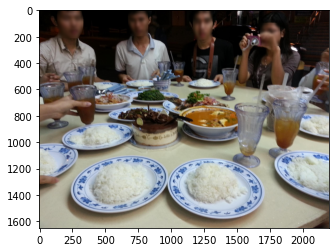

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#img_file = "./ADE20K/img/"+df_ade[df_ade["raw_name"]=="cake"]["filename"].iloc[0]
file = 'ADE_frame_00000119.jpg'
img_file = './ADE20K/img/'+file
image = cv2.imread(img_file)


plt.imshow(image[..., ::-1])
 
plt.show()

In [35]:
from PIL import Image

#read the image
im = Image.open(img_file)

#show image
im.show()


In [36]:
def compute_seg(polygon):
    seg = []
    for x,y in zip(polygon["x"], polygon["y"]):
        seg.append(x)
        seg.append(y)
    return seg
        

df = df_ade[df_ade["filename"]==file]
df["segmentation"] = df["polygon"].apply(compute_seg)

C:\Users\GABRIE~1.FER\AppData\Local\Temp/ipykernel_9196/3341257082.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [37]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', None)

class: wall


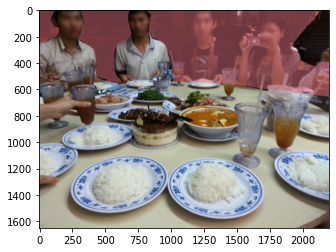

In [38]:
from imantics import Polygons, Mask

print("class:",df.iloc[0]["raw_name"])
plt.imshow(Polygons([df.iloc[0][["polygon", "segmentation"]]["segmentation"]]).mask(image.shape[1],image.shape[0]).draw(image)[..., ::-1])

class: staircase


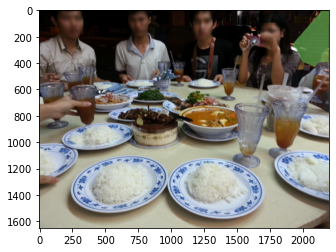

In [39]:
print("class:",df.iloc[1]["raw_name"])
plt.imshow(Polygons([df.iloc[1][["polygon", "segmentation"]]["segmentation"]]).mask(image.shape[1],image.shape[0]).draw(image)[..., ::-1])

class: table


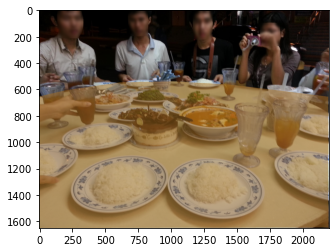

In [40]:
print("class:",df.iloc[2]["raw_name"])
plt.imshow(Polygons([df.iloc[2][["polygon", "segmentation"]]["segmentation"]]).mask(image.shape[1],image.shape[0]).draw(image)[..., ::-1])

class: person


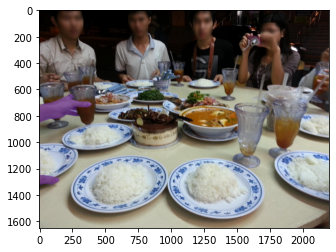

In [41]:
print("class:",df.iloc[4]["raw_name"])
plt.imshow(Polygons([df.iloc[4][["polygon", "segmentation"]]["segmentation"]]).mask(image.shape[1],image.shape[0]).draw(image)[..., ::-1])

class: person


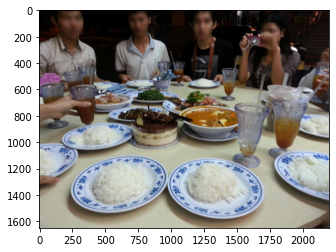

In [42]:
print("class:",df.iloc[5]["raw_name"])
plt.imshow(Polygons([df.iloc[5][["polygon", "segmentation"]]["segmentation"]]).mask(image.shape[1],image.shape[0]).draw(image)[..., ::-1])

class: person


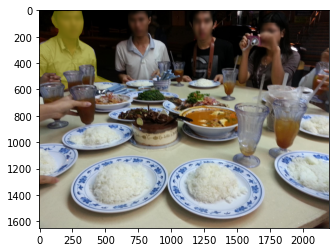

In [43]:
print("class:",df.iloc[6]["raw_name"])
plt.imshow(Polygons([df.iloc[6][["polygon", "segmentation"]]["segmentation"]]).mask(image.shape[1],image.shape[0]).draw(image)[..., ::-1])

class: food


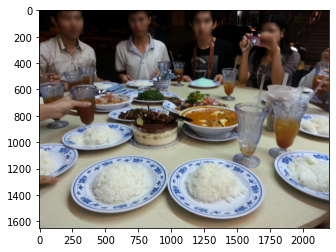

In [44]:
print("class:",df.iloc[45]["raw_name"])
plt.imshow(Polygons([df.iloc[45][["polygon", "segmentation"]]["segmentation"]]).mask(image.shape[1],image.shape[0]).draw(image)[..., ::-1])

class: bowl


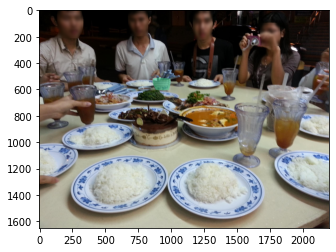

In [45]:
print("class:",df.iloc[50]["raw_name"])
plt.imshow(Polygons([df.iloc[50][["polygon", "segmentation"]]["segmentation"]]).mask(image.shape[1],image.shape[0]).draw(image)[..., ::-1])

class: cake


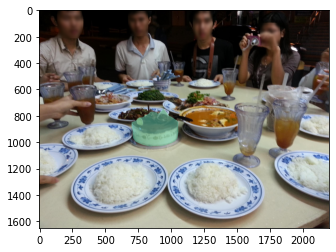

In [46]:
print("class:",df.iloc[99]["raw_name"])
plt.imshow(Polygons([df.iloc[99][["polygon", "segmentation"]]["segmentation"]]).mask(image.shape[1],image.shape[0]).draw(image)[..., ::-1])

# Union of COCO, Lvis and ADE20K

#### Numero totale di immagini: 118.244 + 100.170 + 25.574 = 243.988

In [47]:
df_original_classes["id"] = df_original_classes.index
df_original_classes=df_original_classes[["class","id"]]

df_agg = new_df_coco.append(new_df_lvis).append(new_df_ade)
df_agg = df_agg.groupby(['name']).agg({'count': 'sum'})
df_agg["class"] = df_agg.index

df_dataset = pd.merge(df_agg, df_original_classes, on="class").sort_values(by=['count'], ascending=False)
df_dataset

count        class    id
421  305767       person     3
639  101755         wall     5
653   70507       window     0
110   70328          car    18
621   67945         tree     1
..      ...          ...   ...
297     103          ice   626
74      102      bouquet   913
486     102  scaffolding  1223
526     102         sled  1533
544     101   stabilizer  1008

[662 rows x 3 columns]

In [48]:
df = df_dataset[0:20]
fig = px.histogram(df, 
                   x=df["class"], 
                   y=df["count"], 
                   title="The 20 most frequent classes")
fig.update_yaxes(title="Frequency")
fig.show()

In [49]:
df = df_dataset[-20:]
fig = px.histogram(df, 
                   x=df["class"], 
                   y=df["count"], 
                   title="The 20 least frequent classes")
fig.update_yaxes(title="Frequency")
fig.show() 

In [50]:
print("Numero totale di classi: ",len(set(df_dataset["class"])))

Numero totale di classi:  662


In [51]:
print("classi con almeno 10000 istanze:",len(df_dataset[df_dataset["count"]>=10000]))

classi con almeno 10000 istanze: 77


In [52]:
print("classi con almeno 1000 istanze:",len(df_dataset[df_dataset["count"]>=1000]))

classi con almeno 1000 istanze: 344


In [53]:
print("classi con almeno 500 istanze:",len(df_dataset[df_dataset["count"]>=500]))

classi con almeno 500 istanze: 435


In [54]:
print("classi con almeno 200 istanze:",len(df_dataset[df_dataset["count"]>=200]))

classi con almeno 200 istanze: 565


In [55]:
set(df_dataset["class"].values) - set(df_original_classes["class"].values)

set()

In [60]:
df_coco.rename(columns={"id": "original_id", "name": "class"})[["original_id", "class", "original_class", "dataset"]]

original_id          class  \
0              1         person   
131          199           wall   
2              3            car   
116          184           tree   
119          187            sky   
..           ...            ...   
94           138            net   
12            14  parking meter   
21            23           bear   
70            80        toaster   
78            89     hair dryer   

                                        original_class dataset  
0    {'original_class': 'person', 'original_id': 1,...    COCO  
131  {'original_class': 'wall-other-merged', 'origi...    COCO  
2    {'original_class': 'car', 'original_id': 3, 'd...    COCO  
116  {'original_class': 'tree-merged', 'original_id...    COCO  
119  {'original_class': 'sky-other-merged', 'origin...    COCO  
..                                                 ...     ...  
94   {'original_class': 'net', 'original_id': 138, ...    COCO  
12   {'original_class': 'parking meter', 'original_...    COCO  
21   {'original_class': 'bear', 'original_id': 23, ...    COCO  
70   {'original_class': 'toaster', 'original_id': 8...    COCO  
78   {'original_class': 'hair drier', 'original_id'...    COCO  

[133 rows x 4 columns]

In [64]:
df_dataset_full = df_coco.rename(columns={"id": "original_id", "name": "class"})[["original_id", "class", "original_class", "dataset"]].append(df_lvis.rename(columns={"id": "original_id", "name": "class"})[["original_id", "class", "original_class", "dataset"]]).append(df_ade.rename(columns={"id": "original_id", "name": "class"})[["original_id", "class", "original_class", "dataset", "polygon", "filename"]])

original_id                                              class  \
0                 0                                                sea   
1                 1                                              track   
2                 2                                               sand   
3                 3  person, individual, someone, somebody, mortal,...   
4                 4  backpack, back pack, knapsack, packsack, rucks...   
...             ...                                                ...   
707863            0                                               ring   
707864            1                                      stairs, steps   
707865            2                                           platform   
707866            3                                               wall   
707867            4                          grandstand, covered stand   

                                           original_class dataset  \
0       {'original_class': 'sea water', 'original_id':...  ADE20K   
1       {'original_class': 'track', 'original_id': 1, ...  ADE20K   
2       {'original_class': 'sand beach', 'original_id'...  ADE20K   
3       {'original_class': 'person', 'original_id': 3,...  ADE20K   
4       {'original_class': 'backpack', 'original_id': ...  ADE20K   
...                                                   ...     ...   
707863  {'original_class': 'ring', 'original_id': 0, '...  ADE20K   
707864  {'original_class': 'steps', 'original_id': 1, ...  ADE20K   
707865  {'original_class': 'platform', 'original_id': ...  ADE20K   
707866  {'original_class': 'wall', 'original_id': 3, '...  ADE20K   
707867  {'original_class': 'grandstand', 'original_id'...  ADE20K   

                                                  polygon  \
0       {'x': [0, 0, 197, 234, 275, 342, 381, 426, 452...   
1       {'x': [500, 499, 201, 188, 1, 1, 82, 115], 'y'...   
2       {'x': [499, 499, 463, 447, 421, 398, 359, 306,...   
3       {'x': [350, 350, 346, 345, 344, 347, 346, 346,...   
4       {'x': [354, 356, 357, 354, 351, 351, 349, 349,...   
...                                                   ...   
707863  {'x': [239, 237, 298, 297, 300, 295, 184, 296,...   
707864  {'x': [162, 189, 185, 158, 153, 148, 148, 143,...   
707865  {'x': [50, 51, 78, 80, 225, 224, 232, 241, 237...   
707866  {'x': [50, 172, 175, 175, 175, 85, 84, 77, 76,...   
707867  {'x': [349, 172, 175, 181, 181, 293, 295, 299,...   

                      filename  
0       ADE_frame_00000001.jpg  
1       ADE_frame_00000001.jpg  
2       ADE_frame_00000001.jpg  
3       ADE_frame_00000001.jpg  
4       ADE_frame_00000001.jpg  
...                        ...  
707863    ADE_val_00002000.jpg  
707864    ADE_val_00002000.jpg  
707865    ADE_val_00002000.jpg  
707866    ADE_val_00002000.jpg  
707867    ADE_val_00002000.jpg  

[707868 rows x 6 columns]

In [65]:
print("Numero totale di classi diverse del modello di partenza presenti in COCO: ",len(set(df_dataset_full[df_dataset_full["dataset"]=="COCO"]["class"])))
print("Numero totale di classi diverse del modello di partenza presenti in LVIS: ",len(set(df_dataset_full[df_dataset_full["dataset"]=="LVIS"]["class"])))
print("Numero totale di classi diverse del modello di partenza presenti in ADE20K: ",len(set(df_dataset_full[df_dataset_full["dataset"]=="ADE20K"]["class"])))

Numero totale di classi diverse del modello di partenza presenti in COCO:  127
Numero totale di classi diverse del modello di partenza presenti in LVIS:  521
Numero totale di classi diverse del modello di partenza presenti in ADE20K:  3550


In [56]:
print("Numero totale di classi diverse del modello di partenza presenti in COCO: ",len(set(df_dataset_full[df_dataset_full["dataset"]=="COCO"]["class"])))
print("Numero totale di classi diverse del modello di partenza presenti in LVIS: ",len(set(df_dataset_full[df_dataset_full["dataset"]=="LVIS"]["class"])))
print("Numero totale di classi diverse del modello di partenza presenti in ADE20K: ",len(set(df_dataset_full[df_dataset_full["dataset"]=="ADE20K"]["class"])))

Numero totale di classi diverse del modello di partenza presenti in COCO:  127
Numero totale di classi diverse del modello di partenza presenti in LVIS:  484
Numero totale di classi diverse del modello di partenza presenti in ADE20K:  513


# Open Images 

Numero immagini training: 944.037<br>
Numero di istance masks: 2.686.666

In [ ]:
# https://storage.googleapis.com/openimages/web/factsfigures.html

# https://medium.com/voxel51/loading-open-images-v6-and-custom-datasets-with-fiftyone-18b5334851c3

In [ ]:
df_open_images = pd.read_csv("./open_images/train-annotations-object-segmentation.csv")
print("numero di immagini: ", len(set(df_open_images["ImageID"]))) 
# dataset completo occupa sui 250 GB per le immagini a cui vanno aggiunti quelli delle maschere, quindi occupa più del doppio

In [ ]:
# classi complete
classi = pd.read_csv("./open_images/class-descriptions-boxable.csv", names=["id", "class"], header=None)

# classi segmentazione
file = open("./open_images/classes-segmentation.txt", "r")
classi_segmentazione = file.readlines()
classi_segmentazione = [w.replace('\n', '') for w in classi_segmentazione]

print("numero di classi per la segmentazione: ",len(classi_segmentazione))

# filtro le clasi complete selezionando solo le classi per la segmentazione
classi = classi[classi['id'].isin(classi_segmentazione)]
classi["class"] = classi["class"].str.lower()
classi["class"] = classi["class"].str.replace("_", " ")
classi["class"] = classi["class"].str.replace("-", " ")
classi.head()

In [ ]:
classi["class"] = classi["class"].replace(['adhesive tape'],'tape')
classi["class"] = classi["class"].replace(['alpaca'],'animal')
classi["class"] = classi["class"].replace(['armadillo'],'animal')
classi["class"] = classi["class"].replace(['barge'],'boat')
classi["class"] = classi["class"].replace(['band aid'],'patch')
classi["class"] = classi["class"].replace(['bat (animal)'],'animal')
classi["class"] = classi["class"].replace(['beaker'],'glass')
classi["class"] = classi["class"].replace(['bell pepper'],'pepper')
classi["class"] = classi["class"].replace(['bicycle wheel'],'wheel')
classi["class"] = classi["class"].replace(['billiard table'],'table')
classi["class"] = classi["class"].replace(['blue jay'],'bird')
classi["class"] = classi["class"].replace(['bronze sculpture'],'statue')
classi["class"] = classi["class"].replace(['brown bear'],'bear')
classi["class"] = classi["class"].replace(['burrito'],'food')
classi["class"] = classi["class"].replace(['bust'],'statue')
classi["class"] = classi["class"].replace(['camel'],'animal')
classi["class"] = classi["class"].replace(['canary'],'bird')
classi["class"] = classi["class"].replace(['cantaloupe'],'melon')
classi["class"] = classi["class"].replace(['carnivore'],'animal')
classi["class"] = classi["class"].replace(['cello'],'instrument')
classi["class"] = classi["class"].replace(['cheetah'],'animal')
classi["class"] = classi["class"].replace(['chest of drawers'],'dresser')
classi["class"] = classi["class"].replace(['chopsticks'],'chopstick')
classi["class"] = classi["class"].replace(['cocktail'],'drink')
classi["class"] = classi["class"].replace(['common sunflower'],'sunflower')
classi["class"] = classi["class"].replace(['corded phone'],'phone')
classi["class"] = classi["class"].replace(['cricket ball'],'ball')
classi["class"] = classi["class"].replace(['crocodile'],'animal')
classi["class"] = classi["class"].replace(['digital clock'],'clock')
classi["class"] = classi["class"].replace(['dolphin'],'animal')
classi["class"] = classi["class"].replace(['doughnut'],'donut')
classi["class"] = classi["class"].replace(['falcon'],'bird')
classi["class"] = classi["class"].replace(['fedora'],'hat')
classi["class"] = classi["class"].replace(['flowerpot'],'flower pot')
classi["class"] = classi["class"].replace(['flute'],'instrument')
classi["class"] = classi["class"].replace(['cello'],'instrument')
classi["class"] = classi["class"].replace(['flying disc'],'frisbee')
classi["class"] = classi["class"].replace(['fox'],'animal')
classi["class"] = classi["class"].replace(['frying pan'],'pan')
classi["class"] = classi["class"].replace(['garden asparagus'],'asparagus')
classi["class"] = classi["class"].replace(['goldfish'],'fish')
classi["class"] = classi["class"].replace(['golf ball'],'ball')
classi["class"] = classi["class"].replace(['hamster'],'animal')
classi["class"] = classi["class"].replace(['hand dryer'],'hand towel')
classi["class"] = classi["class"].replace(['handgun'],'gun')
classi["class"] = classi["class"].replace(['harbor seal'],'seal')
classi["class"] = classi["class"].replace(['harmonica'],'instrument')
classi["class"] = classi["class"].replace(['harpsichord'],'instrument')
classi["class"] = classi["class"].replace(['hedgehog'],'animal')
classi["class"] = classi["class"].replace(['high heels'],'shoe')
classi["class"] = classi["class"].replace(['hippopotamus'],'animal')
classi["class"] = classi["class"].replace(['human ear'],'ear')
classi["class"] = classi["class"].replace(['human mouth'],'mouth')
classi["class"] = classi["class"].replace(['jaguar (animal)'],'animal')
classi["class"] = classi["class"].replace(['jeans'],'pant')
classi["class"] = classi["class"].replace(['kangaroo'],'animal')
classi["class"] = classi["class"].replace(['kitchen knife'],'knife')
classi["class"] = classi["class"].replace(['leopard'],'animal')
classi["class"] = classi["class"].replace(['koala'],'animal')
classi["class"] = classi["class"].replace(['limousine'],'car')
classi["class"] = classi["class"].replace(['lizard'],'animal')
classi["class"] = classi["class"].replace(['loveseat'],'couch')
classi["class"] = classi["class"].replace(['luggage and bags'],'bag')
classi["class"] = classi["class"].replace(['lynx'],'animal')
classi["class"] = classi["class"].replace(['magpie'],'bird')
classi["class"] = classi["class"].replace(['maracas'],'instrument')
classi["class"] = classi["class"].replace(['measuring cup'],'cup')
classi["class"] = classi["class"].replace(['microwave oven'],'oven')
classi["class"] = classi["class"].replace(['miniskirt'],'skirt')
classi["class"] = classi["class"].replace(['mobile phone'],'smartphone')
classi["class"] = classi["class"].replace(['mule'],'animal')
classi["class"] = classi["class"].replace(['otter'],'animal')
classi["class"] = classi["class"].replace(['oyster'],'fish')
classi["class"] = classi["class"].replace(['shark'],'fish')
classi["class"] = classi["class"].replace(['snake'],'animal')
classi["class"] = classi["class"].replace(['saxophone'],'instrument')
classi["class"] = classi["class"].replace(['reptile'],'animal')
classi["class"] = classi["class"].replace(['sparrow'],'bird')
classi["class"] = classi["class"].replace(['starfish'],'fish')
classi["class"] = classi["class"].replace(['rugby ball'],'ball')
classi["class"] = classi["class"].replace(['sun hat'],'hat')
classi["class"] = classi["class"].replace(['pretzel'],'bread')
classi["class"] = classi["class"].replace(['plastic bag'],'bag')
classi["class"] = classi["class"].replace(['volleyball (ball)'],'ball')
classi["class"] = classi["class"].replace(['tablet computer'],'tablet')
classi["class"] = classi["class"].replace(['popcorn'],'food')
classi["class"] = classi["class"].replace(['sea lion'],'seal')
classi["class"] = classi["class"].replace(['tortoise'],'animal')
classi["class"] = classi["class"].replace(['rhinoceros'],'animal')
classi["class"] = classi["class"].replace(['waffle'],'food')
classi["class"] = classi["class"].replace(['sea turtle'],'animal')
classi["class"] = classi["class"].replace(['pomegranate'],'fruit')
classi["class"] = classi["class"].replace(['sombrero'],'hat')
classi["class"] = classi["class"].replace(['whale'],'animal')
classi["class"] = classi["class"].replace(['winter melon'],'melon')
classi["class"] = classi["class"].replace(['red panda'],'animal')
classi["class"] = classi["class"].replace(['shorts'],'short')
classi["class"] = classi["class"].replace(['skunk'],'animal')
classi["class"] = classi["class"].replace(['tart'],'cake')
classi["class"] = classi["class"].replace(['pencil case'],'case')
classi["class"] = classi["class"].replace(['squirrel'],'animal')
classi["class"] = classi["class"].replace(['pitcher (container)'],'pitcher')
classi["class"] = classi["class"].replace(['power plugs and sockets'],'socket')
classi["class"] = classi["class"].replace(['pressure cooker'],'pot')
classi["class"] = classi["class"].replace(['raccoon'],'animal')
classi["class"] = classi["class"].replace(['raven'],'bird')
classi["class"] = classi["class"].replace(['roller skates'],'skating')
classi["class"] = classi["class"].replace(['seat belt'],'belt')
classi["class"] = classi["class"].replace(['segway'],'vehicle')
classi["class"] = classi["class"].replace(['slow cooker'],'cooker')
classi["class"] = classi["class"].replace(['snowmobile'],'bike') ######????
classi["class"] = classi["class"].replace(['sofa bed'],'couch')
classi["class"] = classi["class"].replace(['squash (plant)'],'squash')
classi["class"] = classi["class"].replace(['studio couch'],'couch')
classi["class"] = classi["class"].replace(['submarine sandwich'],'sandwich')
classi["class"] = classi["class"].replace(['swimwear'],'swimsuit')
classi["class"] = classi["class"].replace(['table tennis racket'],'tennis racket') ####????
classi["class"] = classi["class"].replace(['turtle'],'animal')
classi["class"] = classi["class"].replace(['waste container'],'waste basket')
classi["class"] = classi["class"].replace(['wok'],'pot')
classi["class"] = classi["class"].replace(['woodpecker'],'bird')
classi["class"] = classi["class"].replace(['segway'],'vehicle')
classi["class"] = classi["class"].replace(['jet ski'],'bike') #####????

In [ ]:
no_match = set(classi["class"].values) - set(df_original_classes["class"].values)
print("numero delle classi non presenti tra quelle del modello di partenza:", len(no_match))
no_match

##### Richiedono molto spazio: 
    - Idea: seleziono solo le classi che mi servono per riempire le classi di minoranza

In [ ]:
#!pip install fiftyone

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

In [ ]:
dataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="train", # posso selezionare il task
    label_types=["detections", "segmentations"], # posso filtrare per classe
    max_samples=100, # posso selezionare quante immagini scaricare,
    seed=51 # posso selezionare il seed per riprodurre i risultati
)

#### Problema: 
Come rappresento un'immagine che contiene una maschera in una matrice che rappresenta la maschera binaria

In [ ]:
path = "C:/Users/gabriele.ferrario/fiftyone/open-images-v6/"
 
f = open(path+'info.json')
data = json.load(f)

In [ ]:
file="segmentations.csv"
segmentations = pd.read_csv(path+"train/labels/"+file)

In [ ]:
segmentations.head()

In [ ]:
len(set(segmentations["LabelName"]))

In [ ]:
len(set(segmentations["ImageID"]))

In [ ]:
segmentations[segmentations["MaskPath"]=="0000b7e1500c94d7_m01yx86_012cc62e.png"]

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_file = path+"train/data/"+segmentations[segmentations["MaskPath"]=="0000b7e1500c94d7_m01yx86_012cc62e.png"]["ImageID"].iloc[0]+".jpg"
image = cv2.imread(img_file)


plt.imshow(image)

In [ ]:
from matplotlib import pylab
mask_file = path+"train/labels/masks/0/"+segmentations[segmentations["MaskPath"]=="0000b7e1500c94d7_m01yx86_012cc62e.png"]["MaskPath"].iloc[0]

matrix = pylab.imread(mask_file)
matrix

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread(mask_file)
img

In [ ]:
from skimage.io import imread
im = imread(mask_file)
im

In [ ]:
# maschera
plt.imshow(im)

In [ ]:
from imantics import Polygons, Mask

polygons = Mask(mask).polygons() # libreria che permette la conversione tra maschera binaria e poligono di segmentazione
plt.imshow(polygons.draw(image))

In [ ]:
polygons